1) Example 1
1. A piece of ______ is on the plate.
2. Everyone enjoys eating ______.
3. You can cut ______ with a knife.
4. We make ______ from milk.
Potential Answers: "cheese," "cake," or "butter"

Step 1: Define the context

Sentence	Context Features
1	“piece of ” ; “ is on the plate”
2	“enjoys eating ___”
3	“cut ___ with a knife”
4	“make ___ from milk”

Step 2: Build a “context‐matching” vector for each candidate

We’ll mark a “1” if that word naturally fits the context, “0” if it doesn’t.

| Candidate | Ctx 1: piece of | Ctx 2: eating | Ctx 3: cut with | Ctx 4: make from | Sum |
|:---------:|:---------------:|:------------:|:---------------:|:----------------:|:----:|
| cheese     | 1               | 1            | 1               | 1                | 4    |
| cake      | 1               | 1            | 1               | 0                | 3    |
| butter    | 0               | 0            | 0               | 1                | 1    |

Cheese has a highest score so that is more apt.

Example 2
1. The ______ is parked in the driveway.
2. He bought a new ______ for his birthday.
3. ______ can drive really fast.
4. People often wash their ______ on the weekends.
Potential Answers: "car," "truck," or "motorcycle"


Step 1: Define the context

Sentence	Context Features
1     “___ is parked in the driveway”
2     “bought a new ___”
3     “___ can drive really fast”
4     “wash their ___ on the weekends”

Step 2: Build a “context‐matching” vector for each candidate

| Candidate     | Parked | Bought new | Drive fast | Wash on weekends | Sum |
|:-------------:|:------:|:----------:|:----------:|:----------------:|:---:|
|   car         | 1      | 1          | 1          | 1                | 4   |
| truck         | 1      | 1          | 0          | 0                | 2   |
| motorcycle    | 1      | 1          | 1          | 0                | 3   |


Car has the highest sum, so it is more apt.


Example 3
1. I read an interesting ______ last night.
2. Many people enjoy a good ______ before bed.
3. ______ often has chapters and a cover.
4. You can borrow a ______ from the library.

Step 1: Define the context

Sentence	Context Features
1   “read an interesting ___”
2   “enjoy a good ___ before bed”
3   “___ often has chapters and a cover”
4   “borrow a ___ from the library”

Step 2: Build a “context‐matching” vector for each candidate

| Candidate  | Interesting | Good before bed | Chapters & cover | Borrow from library | Sum |
|:----------:|:-----------:|:---------------:|:----------------:|:-------------------:|:---:|
| book       | 1           | 1               | 1                | 1                   | 4   |
| novel      | 1           | 1               | 1                | 1                   | 4   |
| story      | 1           | 1               | 0                | 0                   | 2   |


book or novel have the same highest score so they seem to be apt.

2)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankitkumarnath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ankitkumarnath/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ankitkumarnath/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Zero-Shot Cross-Validation AUC:
Logistic Regression: 0.8990
Naive Bayes: 0.8890
SVM: 0.8939

Zero-Shot Leave-One-Plot-Out AUC:
Logistic Regression: 0.9496
Naive Bayes: 0.9486
SVM: 0.9615
Random Forest CV AUC: 0.8513
Random Forest Leave-One-Plot-Out AUC: 0.9258
Generating SBERT embeddings...
Evaluating models...

SBERT Embedding + Model AUC Scores:
Logistic Regression: AUC = 0.9513
SVM: AUC = 0.9415
Naive Bayes: AUC = 0.9319
Random Forest: AUC = 0.9314


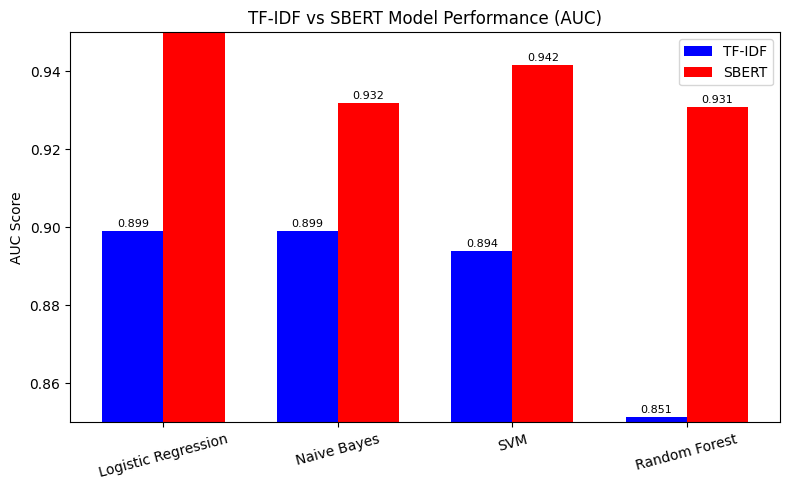

In [16]:
import pandas as pd
import string
import re
import numpy as np
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load your dataset
df = pd.read_csv("data_stories_one_shot.csv")

# Run this once to download required resources
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words]
    return " ".join(tokens)


df["Processed_Sentence"] = df["Sentence"].apply(preprocess)
df["Label"] = df["Stage"].apply(lambda x: 1 if x == 1 else 0)  # Show = 1, Tell = 0

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC()
}

def zero_shot_cross_val(X, y, models):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("clf", model)])
        aucs = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            pipeline.fit(X_train, y_train)
            if name == "SVM":
                scores = pipeline.decision_function(X_test)
            else:
                scores = pipeline.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, scores)
            aucs.append(auc)
        results[name] = np.mean(aucs)
    return results


def zero_shot_leave_one_out(X, y, groups, models):
    logo = LeaveOneGroupOut()
    results = {}

    for name, model in models.items():
        pipeline = Pipeline([("tfidf", TfidfVectorizer()), ("clf", model)])
        aucs = []
        for train_idx, test_idx in logo.split(X, y, groups):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            pipeline.fit(X_train, y_train)
            if name == "SVM":
                scores = pipeline.decision_function(X_test)
            else:
                scores = pipeline.predict_proba(X_test)[:, 1]
            if len(np.unique(y_test)) == 2:
                auc = roc_auc_score(y_test, scores)
                aucs.append(auc)
        results[name] = np.mean(aucs)
    return results


X = df["Processed_Sentence"]
y = df["Label"]
groups = df["Plot_Name"]

cv_results = zero_shot_cross_val(X, y, models)
print("Zero-Shot Cross-Validation AUC:")
for k, v in cv_results.items():
    print(f"{k}: {v:.4f}")

loo_results = zero_shot_leave_one_out(X, y, groups, models)
print("\nZero-Shot Leave-One-Plot-Out AUC:")
for k, v in loo_results.items():
    print(f"{k}: {v:.4f}")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

# Define Random Forest pipeline
rf_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
])

# 5-fold Stratified Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model.fit(X_train, y_train)
    probas = rf_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, probas)
    auc_scores.append(auc)

print(f"Random Forest CV AUC: {np.mean(auc_scores):.4f}")

from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
logo_aucs = []

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model.fit(X_train, y_train)
    if len(np.unique(y_test)) == 2:  # Avoid AUC error if test set lacks class diversity
        probas = rf_model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probas)
        logo_aucs.append(auc)

print(f"Random Forest Leave-One-Plot-Out AUC: {np.mean(logo_aucs):.4f}")

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Load and prepare data
df = pd.read_csv("data_stories_one_shot.csv")
df["Label"] = df["Stage"].apply(lambda x: 1 if x == 1 else 0)

# Generate SBERT embeddings
print("Generating SBERT embeddings...")
sbert = SentenceTransformer('all-MiniLM-L6-v2')
X_sbert = sbert.encode(df["Sentence"].tolist())
y = df["Label"].values

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True)),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Evaluate models using 5-fold CV and AUC
print("Evaluating models...")
results = {}
for name, model in models.items():
    aucs = cross_val_score(model, X_sbert, y, scoring="roc_auc", cv=5)
    results[name] = np.mean(aucs)

# Print results
print("\nSBERT Embedding + Model AUC Scores:")
for model, auc in results.items():
    print(f"{model}: AUC = {auc:.4f}")

import matplotlib.pyplot as plt
import numpy as np

#For cross validation
tfidf_results = {
    "Logistic Regression": 0.8990,
    "Naive Bayes": 0.8990,
    "SVM": 0.8939,
    "Random Forest": 0.8513
}

sbert_results = {
    "Logistic Regression": 0.9513,
    "Naive Bayes": 0.9319,
    "SVM": 0.9415,
    "Random Forest": 0.9308
}

# Plotting
models = list(tfidf_results.keys())
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(x - width/2, [tfidf_results[m] for m in models], width, label='TF-IDF', color="blue")
bar2 = ax.bar(x + width/2, [sbert_results[m] for m in models], width, label='SBERT', color="red")

ax.set_ylabel('AUC Score')
ax.set_title('TF-IDF vs SBERT Model Performance (AUC)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.85, 0.95)
ax.legend()

# Add AUC values on bars
for bar in bar1 + bar2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()